# 3 Teoría de la estimación
## 3.3 Prueba de hipótesis lineal (regresión lineal)

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

In [21]:
# %% Import libraries
from sklearn.linear_model import LinearRegression  # minimos cuadrados
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize  # para minimizar -log-vero
import statsmodels.api as sm
import pandas as pd

El modelo lineal es de la forma

$$
  y = \beta_0 + \beta_1 x
$$

Considerar que el anterior modelo es el proceso generador. Con datos observados, asumimos que el modelo tiene un error de medición $\epsilon_i$

$$
  y_1 = \beta_0 + \beta_1 x_i + \epsilon_i,\quad \text{ con } \epsilon_i \sim \text{Normal}(0, \sigma)
$$

la asunción de que los errores se distribuyen según una variable aleatoria normal con media de 0 y desviación estándar $\sigma$ nos permite usar el método de MLE para obtener estimadores de los parámetros $\beta_0$ y $\beta_1$. Si

$$
  \epsilon_i \sim \text{Normal}(0, \sigma)
$$

y

$$
  \epsilon_i = y_i - (\beta_0 + \beta_1 x_i)
$$

Entonces

$$
  y_i - (\beta_0 + \beta_1 x_i) \sim \text{Normal}(0, \sigma)
$$


In [2]:
# Define the linear model

def linear_model(x, b0, b1):
    return b0 + b1 * x

def neg_log_likelihood(params, x):
    # assign the parameters
    b0 = params[0]
    b1 = params[1]
    sigma = params[2]

    # Compute the predicted values
    y_pred = linear_model(x, b0, b1)

    # Compute the negative log-likelihood of the normal.
    # beware we're using the log transformation of the normal
    nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -
                  0.5 * ((y - y_pred) / sigma)**2)

    return nll


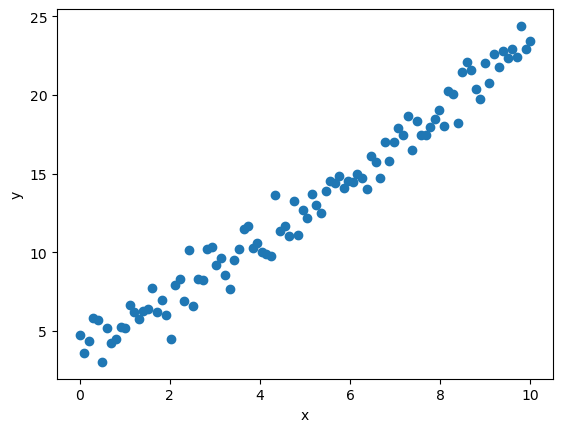

In [3]:
# Generate some data for simple linear regression
np.random.seed(0)
num_samples = 100
x = np.linspace(0, 10, num_samples)
sigma = 1
b0_real = 3
b1_real = 2
epsilon = np.random.normal(0, sigma, num_samples)
y = b0_real + b1_real * x + epsilon

# Plot the data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# Initialize parameters
b0 = 0  # valores iniciales para la funcion minimze
b1 = 0
sigma = 1

# Run the minimization algorithm
# segungo argumento de minimize son los parametros iniciales

result = minimize(neg_log_likelihood, [b0, b1, sigma], args=(x,),
                  method='Nelder-Mead',
                  bounds=[(None, None), (None, None), (0, None)])

residuales = y - result.x[0] - result.x[1] * x

# Print the optimal parameters and the minimum negative log-likelihood
print("Estimates: ")
print("----------------------------")
print("Intercept: %0.2f\nSlope: %0.2f\nSigma: %0.2f\nMean of epsilon_hat: %0.6f" %
      (result.x[0], result.x[1], result.x[2], np.mean(residuales)))

Estimates: 
----------------------------
Intercept: 3.21
Slope: 1.97
Sigma: 1.00
Mean of epsilon_hat: 0.000016


Ahora veremos cómo estimar la variabilidad y el valor p. Usualmente, estos valores se obtienen asumiendo una distribución específica. En jerga estadística, se diría que una distribución límite. Sin embargo, podemos usar un método no paramétrico llamado bootstrapping para estimar la variabilidad de los parámetros.

Pero primero, ¿por qué es necesario estimar la variabilidad?  Por lo siguiente:

Con base en una sola muestra, podemos ver en la simulación anterior que los valores *reales* (que podemos decir que son los valores de la población) son cercanos, pero no idénticos, a los valores estimados.

\begin{align*}
& &\text{ parámetros }\\
&\beta_0 &= 3;\ \beta_1 &= 2\\
&& \text{ estimadores }\\ 
&\hat{\beta_0} &= 3.21;\ \hat{\beta_1} &= 1.97
\end{align*}

Este *error* se considera un error de muestreo. Si repitiéramos el proceso de tomar una muestra, ajustar el modelo, obtener los parámetros, volver a tomar una muestra, etc., obtendríamos una distribución de los estimadores (llamada, justamente, la distribución muestral del estimador). Si repetimos el proceso un número de veces muy grande, la media de la distribución muestral del estimador es igual al estimador del parámetro.

In [12]:
# simularemos el proceso de obtener n_sims muestras de la población, y
# por cada muestra obtendremos los estimadores. Solo para mostrar el concepto
# guardaremos únicamente el slope y obtendremos su media
n_sims = 500

slopes = []
for i in range(n_sims):
  # Generar una muestra
  num_samples = 100
  x = np.linspace(0, 10, num_samples)
  sigma = 1
  b0_real = 3
  b1_real = 2
  epsilon = np.random.normal(0, sigma, num_samples)
  y = b0_real + b1_real * x + epsilon
  # obtener los parámetros
  b0 = 0  # valores iniciales para la funcion minimze
  b1 = 0
  sigma = 1
  result = minimize(neg_log_likelihood, [b0, b1, sigma], args=(x,),
                    method='Nelder-Mead',
                    bounds=[(None, None), (None, None), (0, None)])

  slopes.append(result.x[1])

# la media debe ser más próxima al parámetro real
np.mean(slopes)

/tmp/ipykernel_574207/1659897754.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -
/tmp/ipykernel_574207/1659897754.py:18: RuntimeWarning: divide by zero encountered in true_divide
  0.5 * ((y - y_pred) / sigma)**2)
/tmp/ipykernel_574207/1659897754.py:17: RuntimeWarning: invalid value encountered in subtract
  nll = -np.sum(np.log(1 / (np.sqrt(2 * np.pi) * sigma)) -


2.0033418129237774

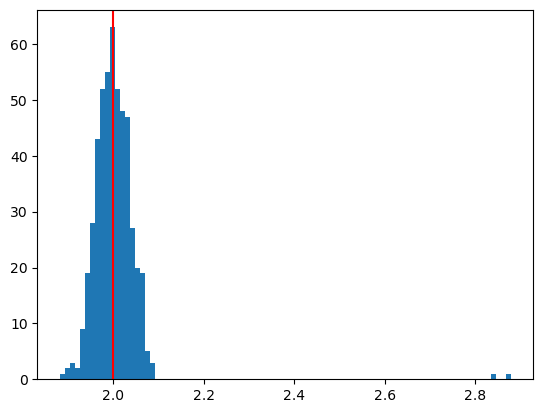

In [18]:
# podemos obtener un histograma de las medias para visualizar qué tan frecuentemente
# encontramos un estimador próximo al estimador real
plt.hist(slopes, bins=90);
plt.axvline(x=b1_real, c='r')

El anterior proceso nos permite entender que la estimación de parámetros no sucede sin errores. Por lo tanto, existe cierta incertidumbre, que llamamos variabilidad en la estimación.

Los métodos usuales para estimar la variabilidad se basan en teoría asintótica, la teoría estadística que nos permite aproximar una distribución con, por ejemplo, una distribución normal. Según esta teoría asintótica, el error estándar. En el contexto de la regresión lineal simple, el error estándar mide la precisión del coeficiente de pendiente estimado. Refleja el grado de variabilidad de las estimaciones de pendiente que se obtendrían si el mismo modelo de regresión se ajustara a diferentes muestras de la misma población. Usualmente se computa con la siguiente fórmula

$$
  SE(\hat{\beta}_1) = \sqrt{ (MSE) / ((n-1) * Var(x)) }
$$

La derivación de esta fórmula se basa en la suposición de que los errores (es decir, las diferencias entre los valores observados de la variable de resultado y los valores pronosticados según el modelo de regresión) se distribuyen normalmente con media cero y varianza constante (es decir, homocedasticidad). Bajo estos supuestos, el estimador de la pendiente es un estimador insesgado de la pendiente verdadera, y su distribución muestral se aproxima a una distribución normal a medida que aumenta el tamaño de la muestra.

El error estándar se puede usar para obtener estimadores del intervalo de confianza. Un intervalo de confianza para la pendiente en una regresión lineal simple es un rango de valores plausibles para la pendiente real en función de la pendiente estimada y su error estándar. Proporciona una medida de la incertidumbre asociada con la estimación de la pendiente y puede ayudarnos a determinar si la relación entre el predictor y las variables de resultado es estadísticamente significativa.

Un intervalo de confianza al $(1-\alpha)$ de probabilidad se calcula sobre un rango de valores. Por ejemplo, si tenemos el rango $[a,b]$, un IC al 95% es un rango tal que la probabilidad de encontrar el valor real del parámetro es del 0.95, es decir

$$
  p(\beta_1 \in [a, b]) = 0.95
$$



Tomar en cuenta que si no se cumplen los supuestos de normalidad y homocedasticidad, es posible que el error estándar no sea preciso y que se utilicen métodos alternativos, como el bootstrapping, para estimar el error estándar. 

Bootstrapping es una técnica estadística para estimar la variabilidad de un estadístico (como la media o el error estándar) mediante el remuestreo de los datos originales. Es un método no paramétrico que no se basa en hacer suposiciones sobre la distribución subyacente de los datos.
En bootstrapping, creamos una gran cantidad de remuestreos mediante muestreo aleatorio del conjunto de datos original con reemplazo. Luego calculamos la estadística de interés (por ejemplo, la media o el error estándar) para cada nueva muestra y usamos la distribución resultante de estas estadísticas para estimar la variabilidad de la estadística.

Usaremos esta técnica para estimar el el error estándar, luego también un intervalo de confianza e inferir algo sobre la pendiente.

In [39]:
from sklearn.linear_model import LinearRegression
np.random.seed(0)
num_samples = 100
x = np.linspace(0, 10, num_samples)
sigma = 1
b0_real = 3
b1_real = 2
epsilon = np.random.normal(0, sigma, num_samples)
y = b0_real + b1_real * x + epsilon

# Define a function to perform bootstrap resampling and fit a regression model
def bootstrap_regression(data):
    sample = data.sample(frac=1, replace=True)
    X = sample[['x']]
    y = sample['y']
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

# Resample the data and compute the p-value
data = pd.DataFrame({'x': x, 'y': y})
n_bootstraps = 1000
slopes = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    slopes[i] = bootstrap_regression(data)

beta_1_hat = result.x[1]
se = np.std(slopes)
print('Standard error of slope:', se.round(2))
ci = np.percentile(slopes, [2.5, 97.5])
print('95% confidence interval of slope:', ci.round(2))


Standard error of slope: 0.04
95% confidence interval of slope: [1.9  2.04]


Para el error estándar, su valor es simplemente la desviación estándar de las pendientes obtenidas por remuestreo.

Para el intervalo de confianza, calculamos los percentiles 2.5 y 97.5 de la distribución resultante de los coeficientes de pendiente para obtener el intervalo de confianza del 95 % para la pendiente. Si el intervalo *no contiene al 0*, se puede inferir que la pendiente no es 0 al 95% de confianza.

In [41]:
model.fit(x.reshape(-1, 1), y)
model.

array([1.97026731])